In [3]:
%matplotlib inline
import matplotlib
from matplotlib import rc
rc('text', usetex=False)
matplotlib.rcParams['svg.fonttype'] = 'none'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import cPickle as pickle
import matplotlib.gridspec as gridspec

### Specify input and output directories
- should contain the "annotated" files from annotator script
- should contain the ".pickle" files from analyze_motifs script (just for the sake of collecting the background ratios)

In [4]:
input_dir = 'inputs/'
output_dir = 'outputs/'

### Read in annotated files
- may need to change the headers if you're not using my (Brian's) annotator (if you're using Eric's, formatting is different)

In [5]:
annotated_headers = [
    'chrom','start','end','l2fc','l10p','strand','geneid','genename','region','annotation'
]
wtss = pd.read_table(
    os.path.join(input_dir, 'WTSS.01v02.IDR.out.0102merged.bed.minus_KOSS.bed.annotated'),
    names=annotated_headers
)
wt3p = pd.read_table(
    os.path.join(input_dir, 'WT3P.01v02.IDR.out.0102merged.bed.minus_KO3P.bed.annotated'),
    names=annotated_headers
)
wt3p.head()

,chrom,start,end,l2fc,l10p,strand,geneid,genename,region,annotation
0,chr21,44268751,44268796,4.609065,3.137124,-,ENSG00000160193.7,WDR4,distintron500,ENST00000330317.2:44263203:44299641:-:transcri...
1,chr3,105293665,105293738,3.115641,3.053569,+,ENSG00000170017.8,ALCAM,3utr,ENST00000491388.2:105293320:105294758:+:exon:E...
2,chr1,204380325,204380375,3.982066,3.137124,-,ENSG00000158615.8,PPP1R15B,CDS,ENST00000367188.4:204372514:204380919:-:transc...
3,chr15,45007620,45007627,11.282413,3.669672,+,ENSG00000166710.13,B2M,CDS,ENST00000557901.1:45003716:45009820:+:transcri...
4,chr15,45007637,45007680,16.882762,3.594680,+,ENSG00000166710.13,B2M,CDS,ENST00000557901.1:45003716:45009820:+:transcri...


### What I label is different from what analyze_motifs gives, so let's make these regions as equivalent as possible.
- I look for: 3UTR, 5UTR, CDS, proxintron500, distintron500, start/stop codons, noncoding_exons, noncoding_introns
- Analyze_motifs: 3UTR, 5UTR, CDS, proxintron500, distintron500
- Need to make these equivalent

In [6]:
def consolidate_noncoding(row):
    """
    This changes some of the annotations to better fit the background.
    I'm replacing all "noncoding intron" and "noncoding exon" annotations with just "noncoding"
    Also replacing any 'codon' regions and labeling them 'CDS' instead.
    """
    if 'noncoding' in row['region']:
        return 'noncoding'
    elif 'codon' in row['region']:
        return 'CDS'
    else:
        return row['region']
    
wtss['consolidated_region'] = wtss.apply(consolidate_noncoding, axis=1)
wt3p['consolidated_region'] = wt3p.apply(consolidate_noncoding, axis=1)

### Plot pie charts using new labels

(-1.1062305366552125,
 1.1002966923476429,
 -1.1156069416001042,
 1.1108083766989569)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1330: UserWarning: findfont: Could not match :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /home/bay001/anaconda2/envs/phenographCluster/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf
  UserWarning)


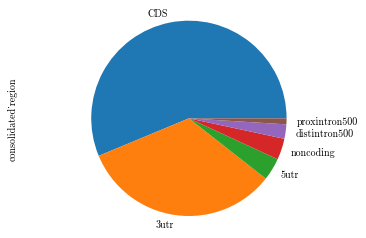

In [7]:
fig, ax = plt.subplots()
wtss['consolidated_region'].value_counts().plot(kind='pie', ax=ax)
ax.axis('equal')

(-1.1126711390291619,
 1.1006033875728172,
 -1.1076858534630774,
 1.1131269572799785)

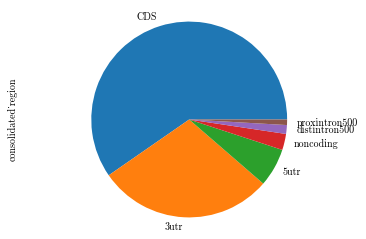

In [8]:
fig, ax = plt.subplots()
wt3p['consolidated_region'].value_counts().plot(kind='pie', ax=ax)
ax.axis('equal')

# Going to drop noncoding regions, which makes things more consistent between fg and bg
- **should be fine since this doesn't make a large percent of the pie for either region** (This depends on the expt)
### revisit if we focus on noncoding genes

In [9]:
wtss = wtss[wtss['consolidated_region']!='noncoding']
wt3p = wt3p[wt3p['consolidated_region']!='noncoding']

wtss = pd.DataFrame(wtss['consolidated_region'].value_counts())
wt3p = pd.DataFrame(wt3p['consolidated_region'].value_counts())

# reorder
wtss = wtss.loc[['CDS','5utr', '3utr', 'proxintron500', 'distintron500']]
wt3p = wt3p.loc[['CDS','5utr', '3utr', 'proxintron500', 'distintron500']]

In [10]:
wtss_exonic = wtss.copy()
wtss_exonic.drop('proxintron500', inplace=True, axis=0)
wtss_exonic.drop('distintron500', inplace=True, axis=0)

wt3p_exonic = wt3p.copy()
wt3p_exonic.drop('proxintron500', inplace=True, axis=0)
wt3p_exonic.drop('distintron500', inplace=True, axis=0)
wtss_exonic

,consolidated_region
CDS,803
5utr,53
3utr,473


# Get genomic and exonic regions (background) based on pickle file
- because I'm lazy and don't want to re-calculate everything...

In [11]:
pickles = sorted(glob.glob(os.path.join(input_dir, '*.pickle')))
print(pickles)
wt3p_pickle = pickle.load(open(pickles[0],'rb'))
wtss_pickle = pickle.load(open(pickles[1],'rb'))

['inputs/WT3P.01v02.IDR.out.0102merged.bed.minus_KO3P.bed.pickle', 'inputs/WTSS.01v02.IDR.out.0102merged.bed.minus_KOSS.bed.pickle']


In [12]:
# actually these are the same values, they should be since the genome backround is the same!
genomic = pd.DataFrame(wt3p_pickle['genic_region_sizes'], index=['sizes']).T
genomic = pd.DataFrame(wtss_pickle['genic_region_sizes'], index=['sizes']).T

# reorder the rows so that the colors match
genomic = genomic.loc[['cds','five_prime_utrs','three_prime_utrs','proxintron500','distintron500']]

# Plot the background pie charts for all regions, as well as exon regions only

(-1.1061731447675971,
 1.1002939592746475,
 -1.1048846473762608,
 1.1049149877270947)

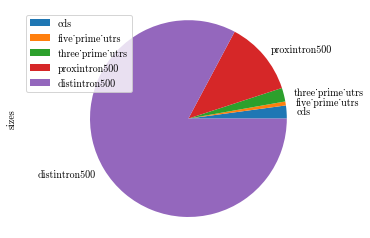

In [13]:
fig, ax = plt.subplots()
genomic.plot(kind='pie', ax=ax, y='sizes')
ax.axis('equal')

In [14]:
exonic = genomic.copy()
exonic.drop('distintron500', inplace=True, axis=0)
exonic.drop('proxintron500', inplace=True, axis=0)

(-1.1072439130455725,
 1.1003449482402654,
 -1.1279847930723974,
 1.1272151386784091)

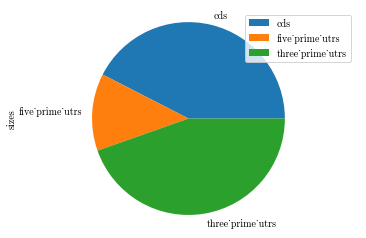

In [15]:
fig, ax = plt.subplots()
exonic.plot(kind='pie', ax=ax, y='sizes')
ax.axis('equal')

# Consolidate all pie charts into a single plot
- row1: genomic region background, WT3P peaks, WTSS peaks
- row2: exonic region background, WT3P exonic peaks, WTSS exonic peaks

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1330: UserWarning: findfont: Could not match :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0. Returning /home/bay001/anaconda2/envs/phenographCluster/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf
  UserWarning)


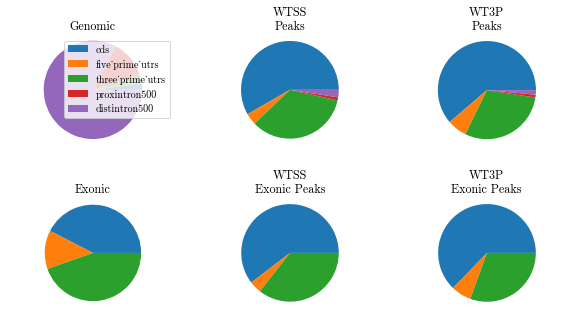

In [16]:
nrows = 2
ncols = 3
full_grid = gridspec.GridSpec(
    nrows, ncols,
    height_ratios=[1 for i in range(nrows)],
    width_ratios=[1 for i in range(ncols)],
    hspace=0.5, wspace=2
)
fig = plt.figure(figsize=(10, 5))
map_rows = []

for row in range(0, nrows):
    map_rows.append(gridspec.GridSpecFromSubplotSpec(
        1, ncols,
        subplot_spec=full_grid[row, :])
    )
    
ax1 = plt.subplot(map_rows[0][0])
ax2 = plt.subplot(map_rows[0][1])
ax3 = plt.subplot(map_rows[0][2])
ax4 = plt.subplot(map_rows[1][0])
ax5 = plt.subplot(map_rows[1][1])
ax6 = plt.subplot(map_rows[1][2])
# ax7 = plt.subplot(map_rows[0][3])

genomic.plot(kind='pie', ax=ax1, y='sizes', legend=True, labels=None)
wtss.plot(kind='pie', ax=ax2, y='consolidated_region', legend=False, labels=None)
wt3p.plot(kind='pie', ax=ax3, y='consolidated_region', legend=False, labels=None)
exonic.plot(kind='pie', ax=ax4, y='sizes', legend=False, labels=None)
wtss_exonic.plot(kind='pie', y='consolidated_region', ax=ax5, legend=False, labels=None)
wt3p_exonic.plot(kind='pie', y='consolidated_region', ax=ax6, legend=False, labels=None)

axs = {ax1:'Genomic', ax2:'WTSS\nPeaks', ax3:'WT3P\nPeaks', ax4:'Exonic', ax5:'WTSS\nExonic Peaks', ax6:'WT3P\nExonic Peaks'}
for ax, title in axs.iteritems():
    ax.set_ylabel('')
    ax.set_title(title)
    ax.axis('equal')
fig.savefig(os.path.join(output_dir, 'region_distributions.svg'))